<a href="https://colab.research.google.com/github/harihardiyan/tdgl-gl-benchmark/blob/main/notebooks/01_single_vortex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Clone your GitHub repo
!git clone https://github.com/harihardiyan/tdgl-gl-benchmark.git
%cd tdgl-gl-benchmark

# Install dependencies
!pip install -r requirements.txt --quiet

Cloning into 'tdgl-gl-benchmark'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (42/42), done.
remote: Total 48 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 23.56 KiB | 11.78 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/tdgl-gl-benchmark


In [2]:

from tdgl_core import (
    init_params_basic,
    init_state_random,
    tdgl_step,
    total_energy,
    to_complex,
)

from tdgl_core.observables import (
    detect_vortices_phase_winding,
    radial_profile,
    gl_profile,
    fit_coherence_length,
)

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [ ]:

# 🌀 Single Vortex Benchmark (TDGL, JAX)

This notebook demonstrates the formation and relaxation of a **single vortex**
in the time‑dependent Ginzburg–Landau (TDGL) model using the JAX‑based solver.

We will:

- Initialize a random superconducting order parameter ψ
- Relax the system under a small external field
- Detect the vortex core using phase winding
- Extract the radial |ψ|² profile
- Fit the analytic GL profile to estimate the coherence length ξ

In [3]:

nx = ny = 64
params = init_params_basic(nx=nx, ny=ny, B0=0.05)
state = init_state_random(params, noise=0.2)

In [4]:

steps = 1500
dt = 0.01

for i in range(steps):
    state = tdgl_step(state, params, dt)

psi = to_complex(state.psi)
dens = jnp.abs(psi)**2
E = total_energy(state, params)

print("Final energy:", float(E))

Final energy: -111.07780456542969


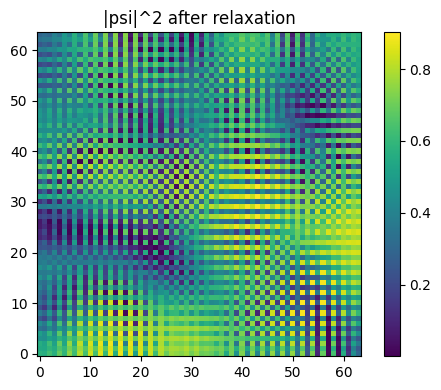

In [5]:

plt.figure(figsize=(5,4))
plt.imshow(dens, origin="lower")
plt.colorbar()
plt.title("|psi|^2 after relaxation")
plt.tight_layout()
plt.show()

Detected vortices: 216


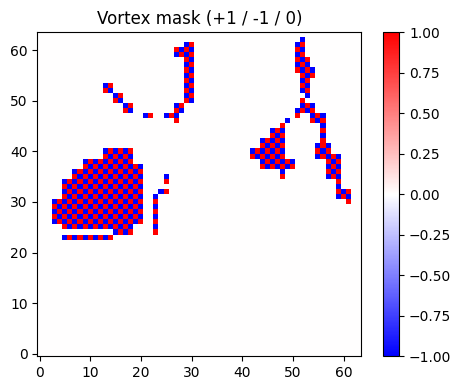

In [6]:

vort_mask = detect_vortices_phase_winding(psi)
coords = jnp.argwhere(vort_mask == 1)

print("Detected vortices:", coords.shape[0])

plt.figure(figsize=(5,4))
plt.imshow(vort_mask, origin="lower", cmap="bwr")
plt.colorbar()
plt.title("Vortex mask (+1 / -1 / 0)")
plt.tight_layout()
plt.show()

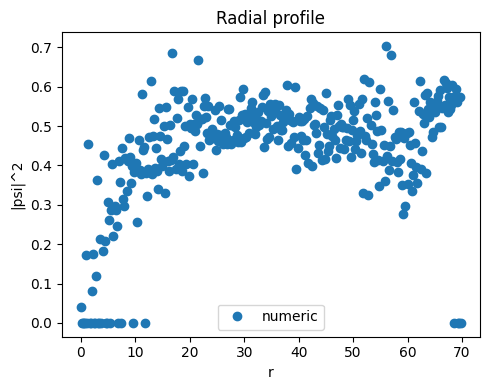

In [7]:

# Pick the first vortex
cy, cx = coords[0]

r, psi_r = radial_profile(dens, center=(cy, cx), dr=0.2)

plt.figure(figsize=(5,4))
plt.plot(r, psi_r, "o", label="numeric")
plt.xlabel("r")
plt.ylabel("|psi|^2")
plt.title("Radial profile")
plt.legend()
plt.tight_layout()
plt.show()

In [8]:

xi_est = fit_coherence_length(r, psi_r)
print("Estimated coherence length ξ ≈", xi_est)

Estimated coherence length ξ ≈ 5.0


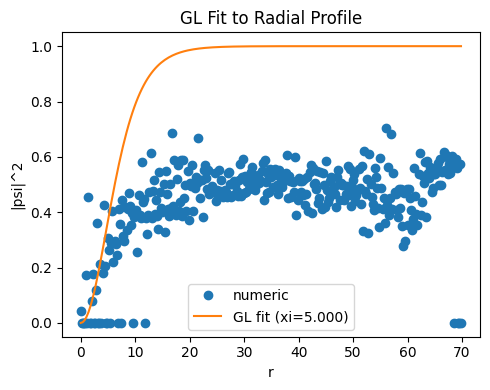

In [9]:

r_dense = jnp.linspace(0, r.max(), 200)
fit_curve = gl_profile(r_dense, xi_est)

plt.figure(figsize=(5,4))
plt.plot(r, psi_r, "o", label="numeric")
plt.plot(r_dense, fit_curve, "-", label=f"GL fit (xi={xi_est:.3f})")
plt.xlabel("r")
plt.ylabel("|psi|^2")
plt.title("GL Fit to Radial Profile")
plt.legend()
plt.tight_layout()
plt.show()